# Machine Learning
### Kernel density estimation (KDE)
**Kernel density estimation** (**KDE**) is a **non-parametric** method for estimating the **probability density function** (**pdf**) of a random variable by placing smooth kernels (like Gaussian) at each data point and summing them.
<br>For data points $x_1$,$x_2$,$...$,$x_n$, the KDE estimate at point $x$ is:
<br>$\large \hat{f}_h(x)=\frac{1}{n\cdot h}\sum_{i=1}^n K(\frac{x-x_i}{h})$ &emsp;(1)
<br> Where:
- $K$: kernel function (non-negative, symmetric, finite variance, integrates to 1)
- $h>0$: bandwidth (smoothing parameter)
- $n$ = number of data points

Common **kernels** include: 
- Gaussian, Epanechnikov, Tophat, Exponential, and Cosine

<hr>

Some rules are suggested for **bandwidth selecion** such as:
- **Silverman's** rule of thumb (Gaussian kernel):
    - $h=1.06 \cdot \hat{\sigma} \cdot n^{−1/5}$ where $\hat{\sigma}=min⁡(\sigma,\frac{IQR}{1.349})$
- **Scott's** rule:
    - $h=\sigma\cdot n^{-1/5}$

**Hint:** To compute PDF for a new point $x$, we first choose the kernel $K$, and the bandwith $h$. Then, we estimate the PDF at point $x$ ($pdf(x)$) by using formula (1) with $x$ and given $n$ data points $x_i$. 
<hr>

In the following, 
- We implement Kernel Density Estimation (KDE) from scratch by defining a `class` in python. 
- Then, we test the KDE with synthetic data composed of samples of two normal distributions. 
- Next, we dispaly the kernel functions for comparison. 
- Finally, as a bonus, we use `KernelDensity` of **Scikit-learn** to implmenet KDE.

<hr>

https://github.com/ostad-ai/Machine-Learning
<br> Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning/

In [1]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class KDE:
    """Kernel Density Estimation from Scratch"""
    
    def __init__(self, bandwidth=None, kernel='gaussian'):
        """
        Parameters:
        bandwidth: Smoothing parameter (if None, auto-compute)
        kernel: 'gaussian', 'epanechnikov', 'tophat', 'exponential'
        """
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.data = None
        self.n = None
        self.h = None
        
    def _compute_bandwidth(self, data):
        """Compute bandwidth using Silverman's rule"""
        n = len(data)
        sigma = np.std(data)
        
        # Compute IQR for robust sigma estimate
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        sigma_robust = min(sigma, iqr / 1.349) if iqr > 0 else sigma
        
        # Silverman's rule of thumb
        h = 1.06 * sigma_robust * n ** (-0.2)
        return h
    
    def _gaussian_kernel(self, u):
        """Gaussian kernel function"""
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)
    
    def _epanechnikov_kernel(self, u):
        """Epanechnikov kernel function (optimal for mean squared error)"""
        return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)
    
    def _tophat_kernel(self, u):
        """Tophat/Box kernel function"""
        return np.where(np.abs(u) <= 1, 0.5, 0)
    
    def _exponential_kernel(self, u):
        """Exponential kernel function"""
        return 0.5 * np.exp(-np.abs(u))
    
    def _cosine_kernel(self, u):
        """Cosine kernel function"""
        return np.where(np.abs(u) <= 1, (np.pi / 4) * np.cos((np.pi / 2) * u), 0)
    
    def _kernel_function(self, u):
        """Dispatch to appropriate kernel function"""
        if self.kernel == 'gaussian':
            return self._gaussian_kernel(u)
        elif self.kernel == 'epanechnikov':
            return self._epanechnikov_kernel(u)
        elif self.kernel == 'tophat':
            return self._tophat_kernel(u)
        elif self.kernel == 'exponential':
            return self._exponential_kernel(u)
        elif self.kernel == 'cosine':
            return self._cosine_kernel(u)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
    
    def fit(self, data):
        """Fit KDE to data"""
        self.data = np.asarray(data).flatten()
        self.n = len(self.data)
        
        # Compute bandwidth if not provided
        if self.bandwidth is None:
            self.h = self._compute_bandwidth(self.data)
        else:
            self.h = self.bandwidth
            
        return self
    
    def evaluate(self, points):
        """Evaluate KDE at given points"""
        points = np.asarray(points).flatten()
        density = np.zeros_like(points, dtype=float)
        
        # For each evaluation point
        for i, x in enumerate(points):
            # Compute u = (x - x_i) / h for all data points
            u = (x - self.data) / self.h
            
            # Apply kernel function
            kernel_values = self._kernel_function(u)
            
            # Sum and normalize
            density[i] = np.sum(kernel_values) / (self.n * self.h)
        
        return density
    
    def pdf(self, points):
        """Alias for evaluate (probability density function)"""
        return self.evaluate(points)

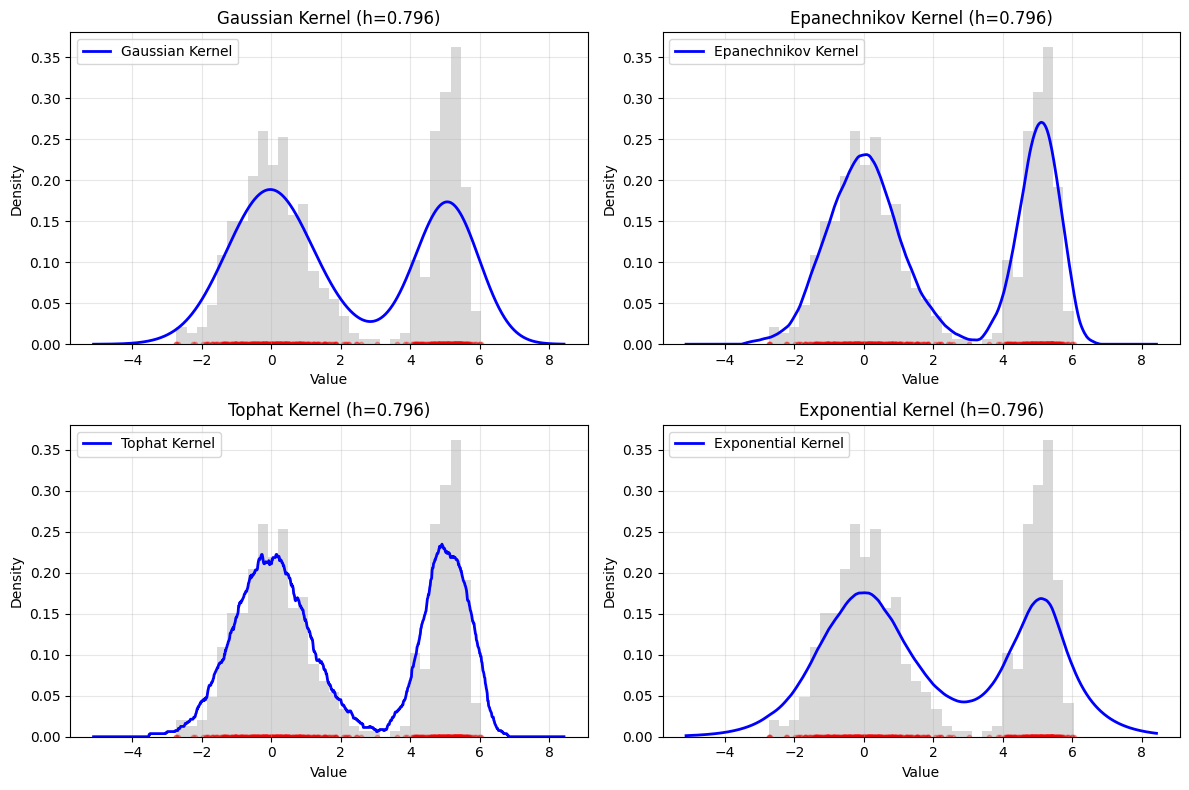

In [3]:
# Data
data = np.concatenate([
    np.random.normal(0, 1, 300),
    np.random.normal(5, 0.5, 200)
])

# Example: Different kernels
kernels = ['gaussian', 'epanechnikov', 'tophat', 'exponential']

plt.figure(figsize=(12, 8))

for i, kernel in enumerate(kernels, 1):
    kde = KDE(kernel=kernel)
    kde.fit(data)
    
    # Create evaluation points
    x_min, x_max = np.min(data), np.max(data)
    padding = 3 * kde.h
    x = np.linspace(x_min - padding, x_max + padding, 1000)
    y = kde.pdf(x)
    
    # Plot in subplot
    plt.subplot(2, 2, i)
    plt.plot(x, y, 'b-', linewidth=2, label=f'{kernel.capitalize()} Kernel')
    plt.hist(data, bins=30, density=True, alpha=0.3, color='gray')
    plt.scatter(data, np.zeros_like(data), alpha=0.3, color='red', s=10)
    plt.title(f'{kernel.capitalize()} Kernel (h={kde.h:.3f})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

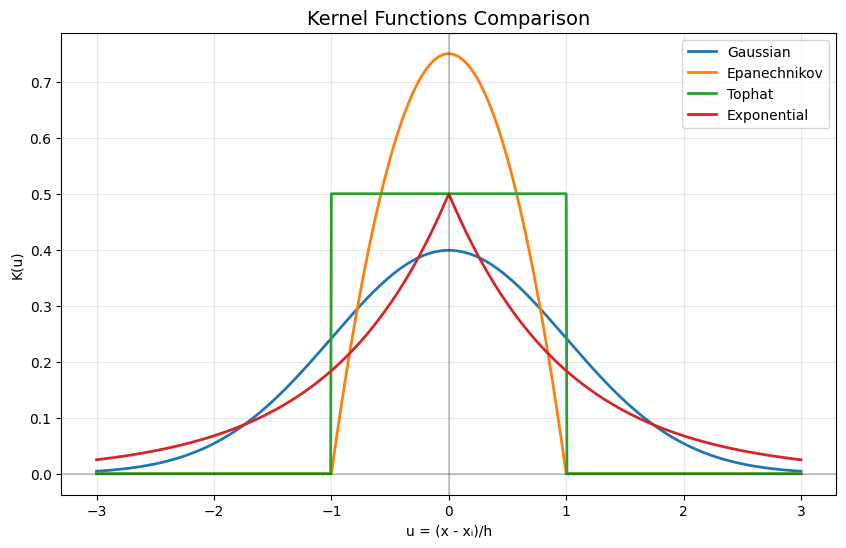

In [4]:
# Extra
# Plot the kernel functions themselves for comparison
def plot_kernel_functions():
    """Visualize different kernel functions"""
    u = np.linspace(-3, 3, 1000)
    
    kernels = {
        'Gaussian': (1/np.sqrt(2*np.pi)) * np.exp(-0.5*u**2),
        'Epanechnikov': np.where(np.abs(u) <= 1, 0.75*(1-u**2), 0),
        'Tophat': np.where(np.abs(u) <= 1, 0.5, 0),
        'Exponential': 0.5 * np.exp(-np.abs(u))
    }
    
    plt.figure(figsize=(10, 6))
    for name, values in kernels.items():
        plt.plot(u, values, label=name, linewidth=2)
    
    plt.title('Kernel Functions Comparison', fontsize=14)
    plt.xlabel('u = (x - xᵢ)/h')
    plt.ylabel('K(u)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.2)
    plt.show()

plot_kernel_functions()

<hr style="height:3px; background-color:lightblue">

# Bonus
#### We use `KernelDensity` in Scikit-Learn for KDE

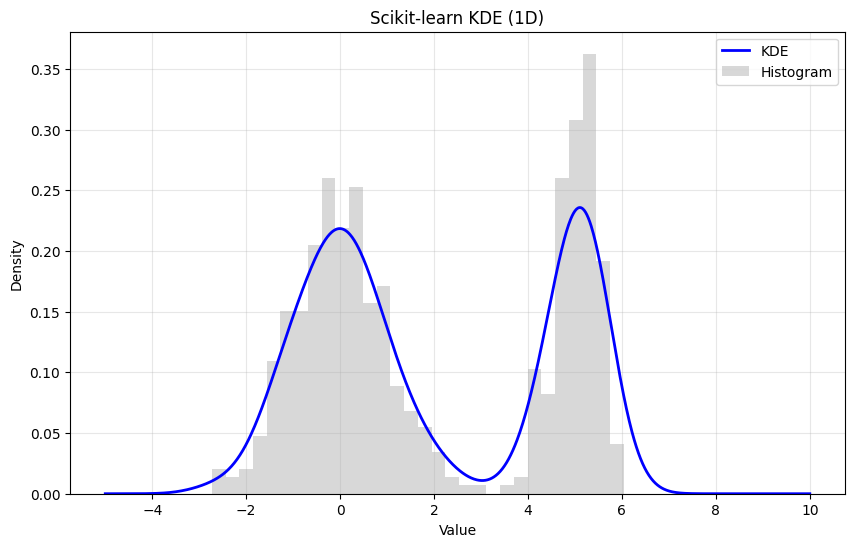

In [5]:
# Bonus
from sklearn.neighbors import KernelDensity

# Create and fit KDE
kde2 = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde2.fit(data.reshape(-1,1)) # must be 2D array

# Evaluate on grid
x_grid = np.linspace(-5, 10, 1000).reshape(-1, 1)
log_density = kde2.score_samples(x_grid)
density = np.exp(log_density)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_grid, density, 'b-', linewidth=2, label='KDE')
plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label='Histogram')
plt.title('Scikit-learn KDE (1D)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()